In [1]:
import pandas as pd
import numpy as np

In [2]:
df_fake=pd.read_csv("Fake.csv")
df_true=pd.read_csv("True.csv")

In [3]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
df_fake['label']='fake'
df_true['label']='real'

In [6]:
df=pd.concat([df_fake,df_true],axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [8]:
df.reset_index(inplace=True)
df=df.drop('index', axis=1)

In [9]:
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",real
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",real
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",real
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",real


In [10]:
data_distribution = df.groupby('label').size()
data_distribution

label
fake    23481
real    21417
dtype: int64

<AxesSubplot: ylabel='label'>

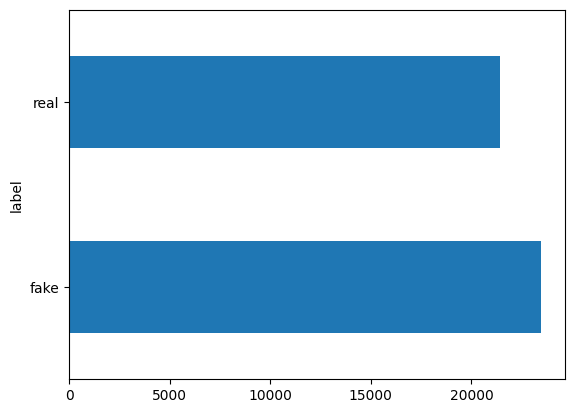

In [11]:
data_distribution_sorted = data_distribution.sort_values(ascending=False)
data_distribution_sorted.plot(kind='barh')

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['text'],df['label'],test_size=0.2,random_state=42)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english',max_df=0.75)
train_tf_idf=tfidf_vectorizer.fit_transform(x_train)
test_tfidf=tfidf_vectorizer.transform(x_test)

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_tfidf, y_trains = smote.fit_resample(train_tf_idf, y_train)

In [15]:
print(train_tfidf.shape)
print(y_trains.shape)
print(test_tfidf.shape)
print(y_test.shape)

(37496, 111112)
(37496,)
(8980, 111112)
(8980,)


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers=[('Logistic Regression',LogisticRegression()),
            ('MultiNomial Naives Bayes',MultinomialNB()),
            ('Decision Tree Classifier',DecisionTreeClassifier()),
            ('Random Forest Clasifier',RandomForestClassifier(max_depth=2,random_state=42))]

pipelines=[]

for classifiername,classifier in classifiers:
  pipeline=Pipeline([('classifier:',classifier)])
  pipelines.append((classifiername,pipeline))

In [17]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

for classifier_name,pipeline in pipelines:
  print(f'Training and Testing:{classifier_name}')
  pipeline.fit(train_tfidf,y_trains)
  y_prediction=pipeline.predict(test_tfidf)
  score=accuracy_score(y_test,y_prediction)
  confuse_matrix=confusion_matrix(y_test,y_prediction,labels=['fake','real'])
  f1score=f1_score(y_test,y_prediction,pos_label="real")
  classify=classification_report(y_test,y_prediction)
  print(f'Accuracy score:{round(score*100,2)}%')
  print(f'confusion Matrix:{confuse_matrix}')
  print(f'F1_score:{round(f1score*100,2)}%')
  print(f'classification report:{classify}')

Training and Testing:Logistic Regression
Accuracy score:98.61%
confusion Matrix:[[4658   75]
 [  50 4197]]
F1_score:98.53%
classification report:              precision    recall  f1-score   support

        fake       0.99      0.98      0.99      4733
        real       0.98      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Training and Testing:MultiNomial Naives Bayes
Accuracy score:93.54%
confusion Matrix:[[4403  330]
 [ 250 3997]]
F1_score:93.24%
classification report:              precision    recall  f1-score   support

        fake       0.95      0.93      0.94      4733
        real       0.92      0.94      0.93      4247

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

Training and Testing:Decision Tree Classifier
Accur

In [18]:
News=input("Enter the News:")
for classifier_name,pipeline in pipelines:
  pipeline.fit(train_tfidf,y_trains)
  tests_tfidf=tfidf_vectorizer.transform([News])
  print(f'{classifier_name:} prediction')
  prediction=pipeline.predict(tests_tfidf)
  print(prediction[0])

Logistic Regression prediction
fake
MultiNomial Naives Bayes prediction
real
Decision Tree Classifier prediction
fake
Random Forest Clasifier prediction
real


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ce02cbbe-2a51-4d5d-a5d9-348c2a41c888' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>